# Train ADAGE models on RNAseq data

### Georgia Doing 2021

This notebook walks through the training of an RNAseq-based ADAGE model as a continuation of analyses from last year (2021_06_eADAGE_adapt/seqADAGE).

Since then we have downloaded a new compendium of RNAseq data and aligned it to the PAO1 and PA14 reference genomes using prokarytoic-optimized parameters.
(https://github.com/hoganlab-dartmouth/pa-seq-compendia)

The main objectives are to train models, take a first look and save the models for further analysis on forthcoming notebooks
1. Load compendia
2. Train and save models
3. Visualize first-look plots

In [3]:
import run_count_autoencoder
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
from scipy.stats import hypergeom
import csv
import TiedWeightsEncoder

In [21]:
# for dev purposes, while updating run_model.py need to reload
reload(run_count_autoencoder)
reload(run_model)
reload(Adage)
reload(TiedWeightsEncoder)

<module 'TiedWeightsEncoder' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/TiedWeightsEncoder.py'>

In [4]:
array_comp = pd.read_csv(open('../data_files/train_set_normalized.csv', "rb"),index_col=0)
seq_comp_floor = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log.csv', "rb"),index_col=0)
seq_comp = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv', "rb"),index_col=0)
print(seq_comp.shape)
print(seq_comp_floor.shape)
print(array_comp.shape)

(5563, 2766)
(5563, 2766)
(5549, 950)


<AxesSubplot:ylabel='Density'>

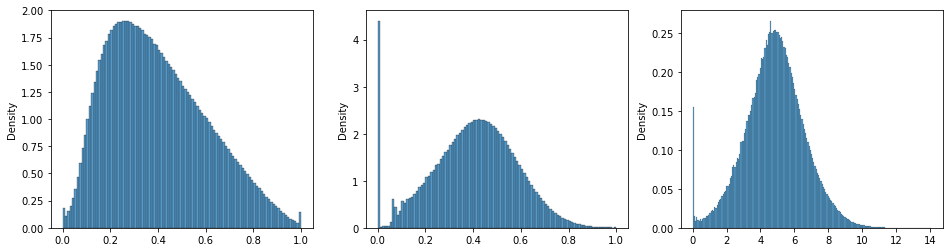

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16 ,4))
sns.histplot(array_comp.to_numpy().flatten(),binwidth=0.01, stat='density',ax=ax1)
sns.histplot(seq_comp.to_numpy().flatten(),binwidth=0.01,stat='density',ax=ax2)
sns.histplot(seq_comp_floor.to_numpy().flatten(), bins=200,stat='density',ax=ax3)

In [13]:
m = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log.csv',lr=.0001,seed=460,kl1=1e-10,kl2=1e-1, act = 'sigmoid', tied = True, epochs=5, init='glorot_uniform', batch_size=10, v=0)
tf_adage = Adage.Adage(m.autoencoder, m.history, m.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(5549, 600)

[Text(0.5, 1.0, 'k_adage')]

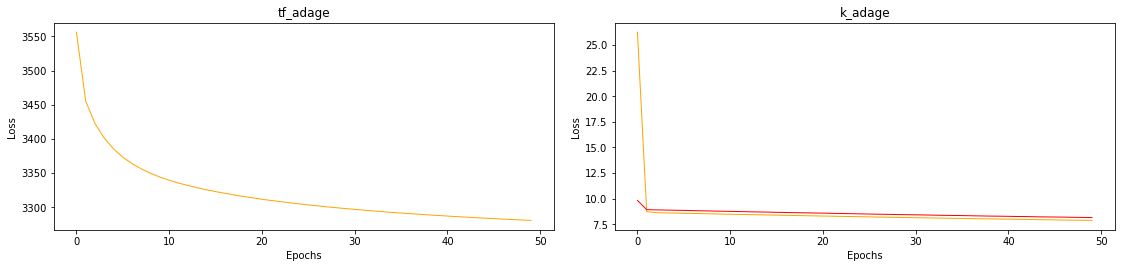

In [19]:
model_dict = {
    "tf_adage": tf_adage,
    "k_adage": m
}
fig, ax = plt.subplots(1, 2,figsize=(16 ,4))
fig.tight_layout(pad=3.0)

name = 'tf_adage'
model_temp = model_dict[name]
ax[0].plot(list(range(0,50)), model_temp.loss[0:50], linewidth=1, markersize=2, color = 'orange')
ax[0].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
ax[0].set(title = name)

name = 'k_adage'
model_temp = model_dict[name]
ax[1].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
ax[1].plot(list(range(0,50)), model_temp.val_loss, linewidth=1, markersize=2, color = 'red')
ax[1].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
ax[1].set(title = name)

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5, 1e-10]
L2_norm = [0, 1e-5, 1e-10]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.001]

model_dict_da = {
    "tf_adage": tf_adage
}
model_dict_dca = {
    "tf_adage": tf_adage
}
model_dict_dca01 = {
    "tf_adage": tf_adage
}
model_dict_arr = {
    "tf_adage": tf_adage
}

for seed in range(3):
    for w in tied:
        for i in inits:
            #print(i)
            for l in L1_norm:
                #print(l)
                for n in L2_norm:
                    for a in act_fun:
                       # print(a)
                        for t in lr:
                            #print(t)
                            name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                            print(name)
                            m_arr = run_model.run_model('../data_files/train_set_normalized.csv',seed=seed+560,lr=t,kl1=l, kl2=n, act = a, tied = w, epochs=50, init=i, batch_size = 10,v=0)
                            m_da = run_model.run_model('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv',seed=seed+560,lr=t,kl1=l,kl2=n, act = a, tied = w, epochs=50, init=i, batch_size = 10,v=0)
                            m_dca01 = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv',seed=seed+560,lr=t,kl1=l,kl2=n, act = a, tied = w, epochs=50, init=i, batch_size = 10,v=0)
                            m_dca = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log.csv',seed=seed+560,lr=t,kl1=l,kl2=n, act = a, tied = w, epochs=50, init=i, batch_size = 10,v=0)

                            model_dict_arr[name] = m_arr
                            model_dict_da[name] = m_da
                            model_dict_dca01[name] = m_dca01
                            model_dict_dca[name] = m_dca

ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5


In [7]:
print(model_dict_da.keys())
print(model_dict_dca.keys())

dict_keys(['tf_adage'])
dict_keys(['tf_adage'])


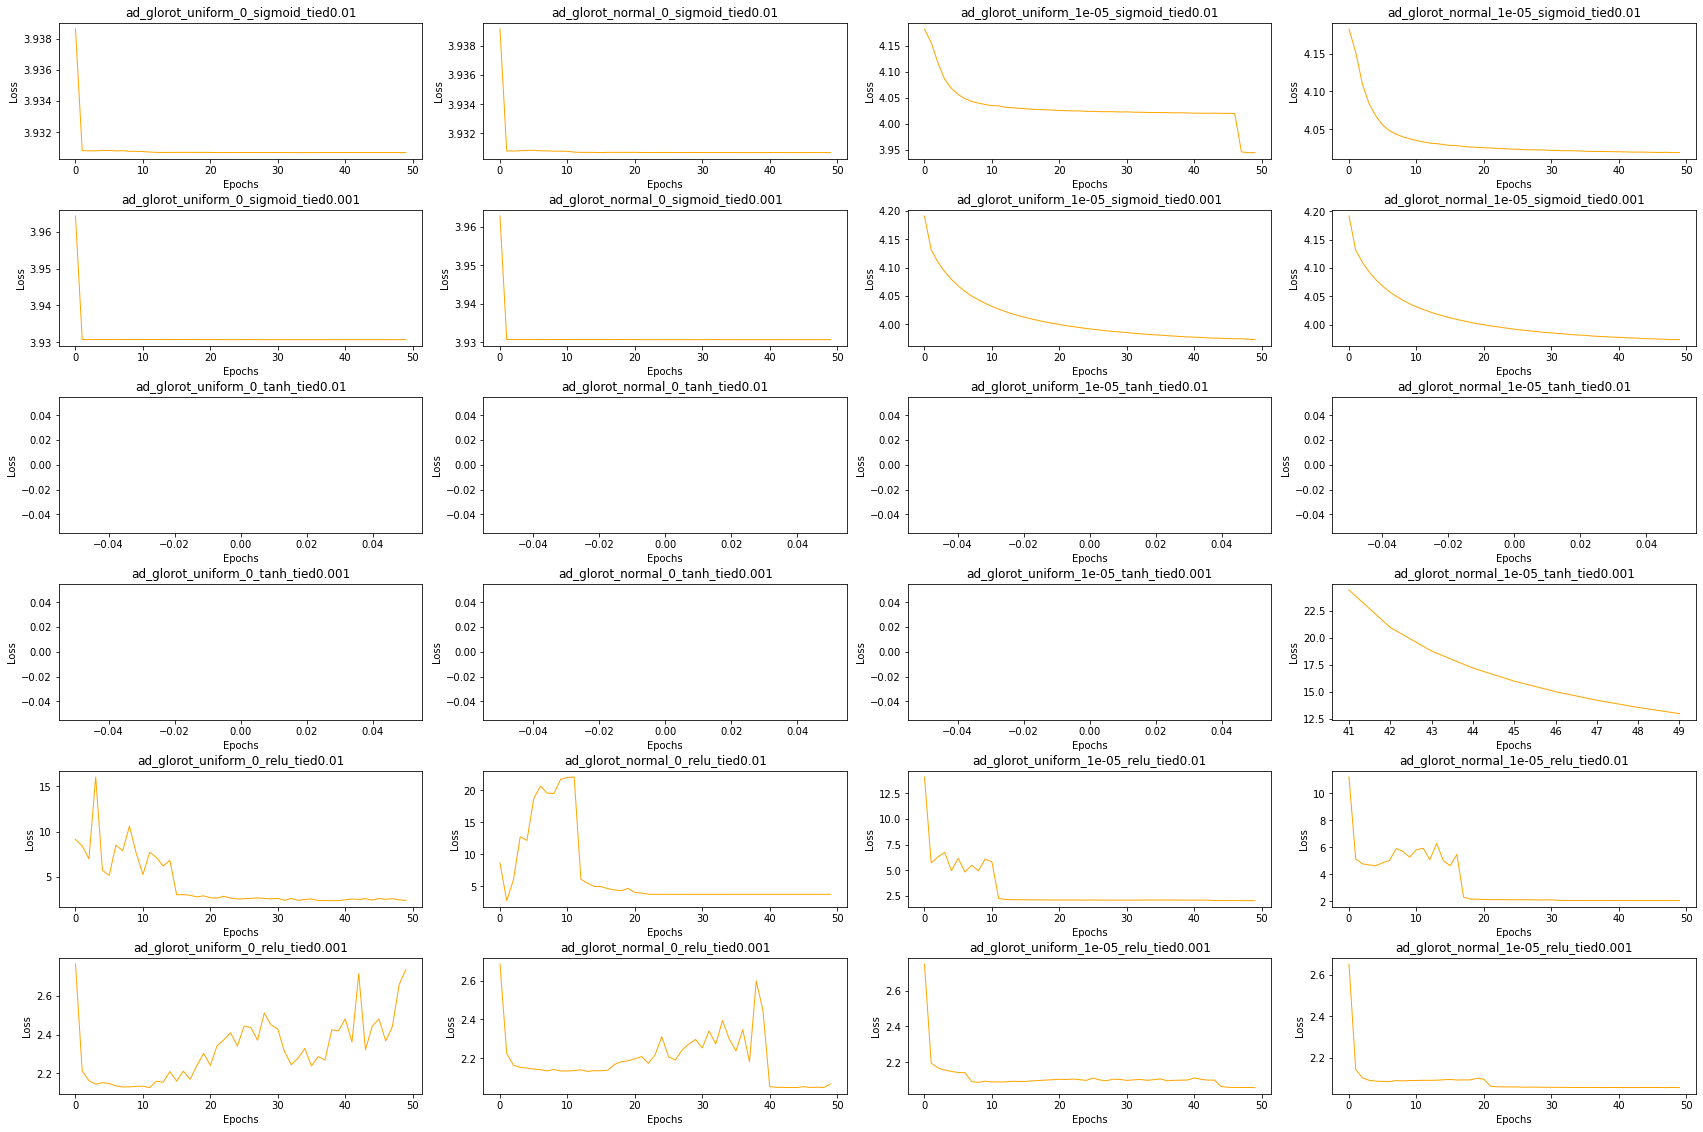

In [20]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in lr:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                #print(name)
                model_temp = model_dict_da[name]
                ax[xi,yi].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    

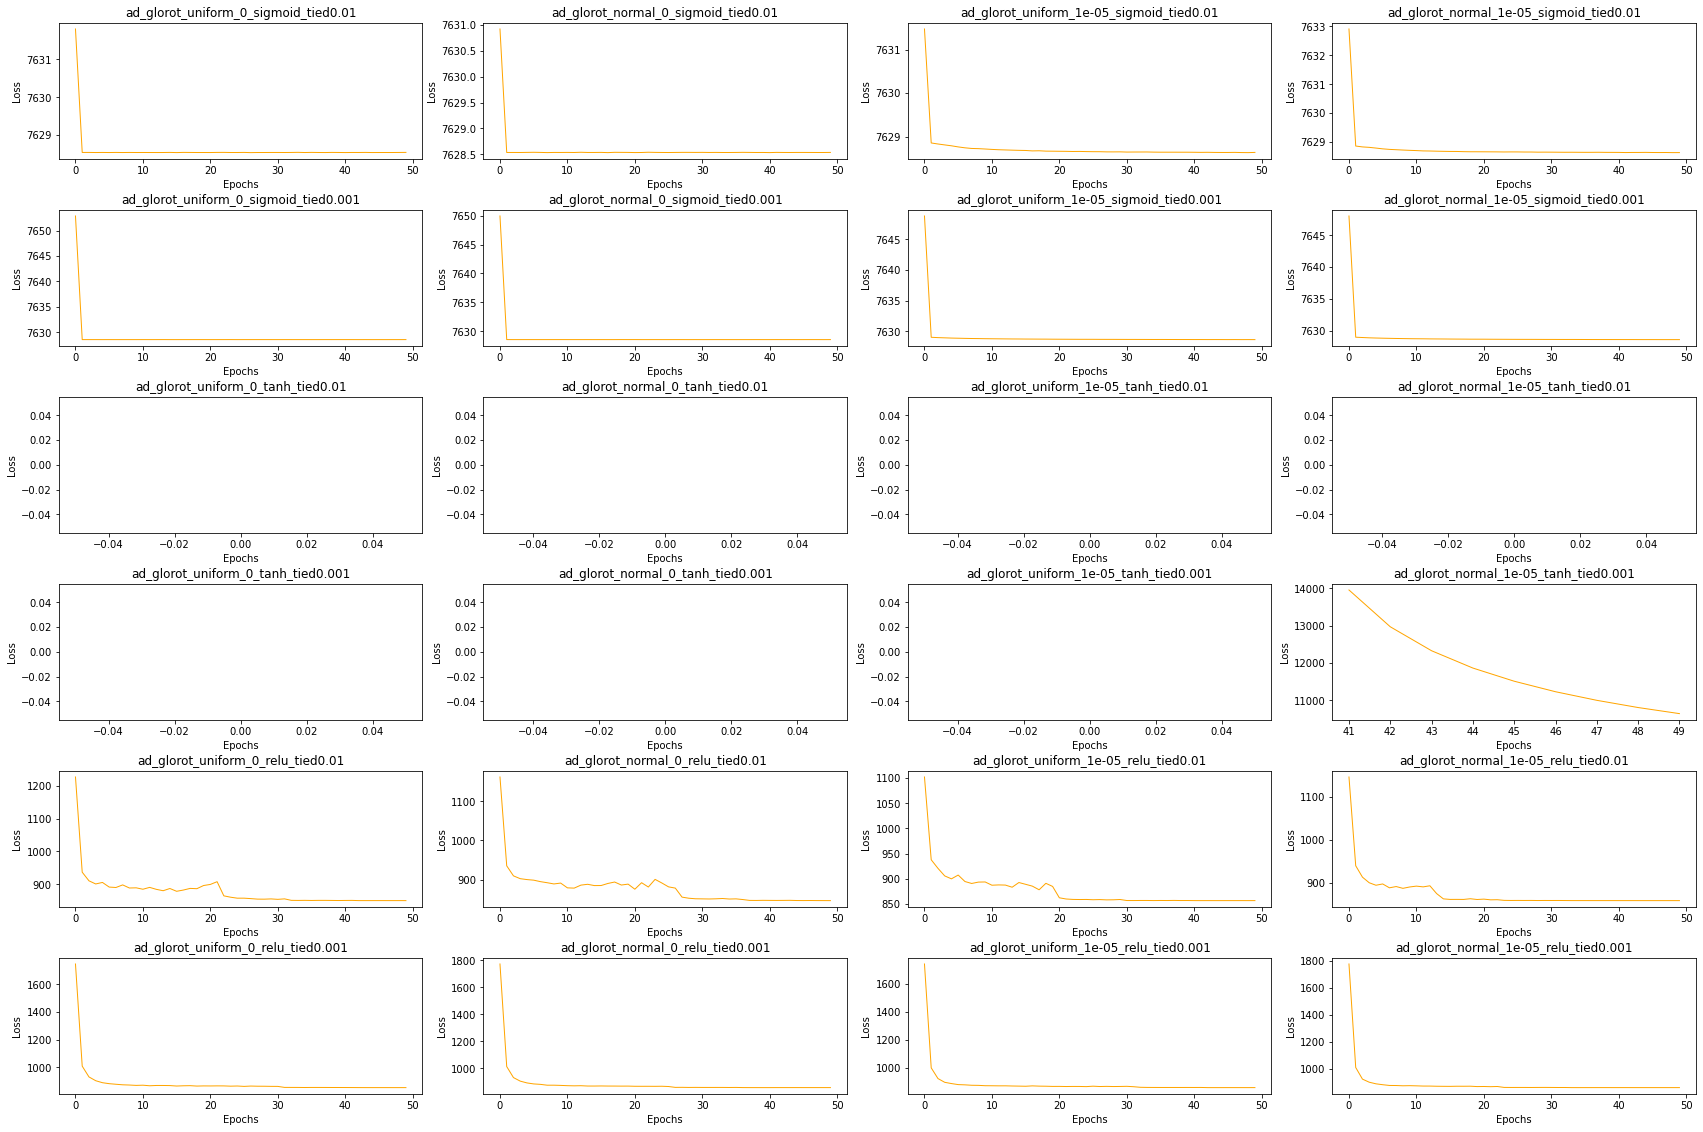

In [21]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in lr:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                #print(name)
                model_temp = model_dict_dca[name]
                ax[xi,yi].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    